In [7]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
try:
    from torchvision import transforms, utils
except:
    !conda install --yes torchvision --no-channel-priority
    from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
try:
    from torchvision import transforms, utils
except:
    !pip install torchvision
    from torchvision import transforms, utils
from PIL import Image

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# You want to change these to be your own filenames
csv_file = 'flood_sample_metadata.csv'
label_csv = 'flood_sample_label.csv'

In [8]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 50

In [9]:
# read the tsv file with the labels
ladi_responses = pd.read_csv("http://ladi.s3-us-west-2.amazonaws.com/Labels/ladi_aggregated_responses_url.tsv",delimiter='\t',header='infer')
ladi_responses.head(1000)

url  WorkerId  \
0    https://ladi.s3-us-west-2.amazonaws.com/Images...         0   
1    https://ladi.s3-us-west-2.amazonaws.com/Images...         1   
2    https://ladi.s3-us-west-2.amazonaws.com/Images...         2   
3    https://ladi.s3-us-west-2.amazonaws.com/Images...        20   
4    https://ladi.s3-us-west-2.amazonaws.com/Images...         0   
5    https://ladi.s3-us-west-2.amazonaws.com/Images...         8   
6    https://ladi.s3-us-west-2.amazonaws.com/Images...         9   
7    https://ladi.s3-us-west-2.amazonaws.com/Images...         0   
8    https://ladi.s3-us-west-2.amazonaws.com/Images...         1   
9    https://ladi.s3-us-west-2.amazonaws.com/Images...        11   
10   https://ladi.s3-us-west-2.amazonaws.com/Images...         0   
11   https://ladi.s3-us-west-2.amazonaws.com/Images...         7   
12   https://ladi.s3-us-west-2.amazonaws.com/Images...        11   
13   https://ladi.s3-us-west-2.amazonaws.com/Images...         0   
14   https://ladi.s3-us-west-2.amazonaws.com/Images...         0   
15   https://ladi.s3-us-west-2.amazonaws.com/Images...         8   
16   https://ladi.s3-us-west-2.amazonaws.com/Images...         8   
17   https://ladi.s3-us-west-2.amazonaws.com/Images...        12   
18   https://ladi.s3-us-west-2.amazonaws.com/Images...        12   
19   https://ladi.s3-us-west-2.amazonaws.com/Images...         0   
20   https://ladi.s3-us-west-2.amazonaws.com/Images...         1   
21   https://ladi.s3-us-west-2.amazonaws.com/Images...        15   
22   https://ladi.s3-us-west-2.amazonaws.com/Images...         0   
23   https://ladi.s3-us-west-2.amazonaws.com/Images...        10   
24   https://ladi.s3-us-west-2.amazonaws.com/Images...        11   
25   https://ladi.s3-us-west-2.amazonaws.com/Images...         0   
26   https://ladi.s3-us-west-2.amazonaws.com/Images...         3   
27   https://ladi.s3-us-west-2.amazonaws.com/Images...        11   
28   https://ladi.s3-us-west-2.amazonaws.com/Images...         0   
29   https://ladi.s3-us-west-2.amazonaws.com/Images...         3   
30   https://ladi.s3-us-west-2.amazonaws.com/Images...        13   
31   https://ladi.s3-us-west-2.amazonaws.com/Images...         0   
32   https://ladi.s3-us-west-2.amazonaws.com/Images...         6   
33   https://ladi.s3-us-west-2.amazonaws.com/Images...         9   
34   https://ladi.s3-us-west-2.amazonaws.com/Images...         0   
35   https://ladi.s3-us-west-2.amazonaws.com/Images...         0   
36   https://ladi.s3-us-west-2.amazonaws.com/Images...         1   
37   https://ladi.s3-us-west-2.amazonaws.com/Images...         1   
38   https://ladi.s3-us-west-2.amazonaws.com/Images...        11   
39   https://ladi.s3-us-west-2.amazonaws.com/Images...        11   
40   https://ladi.s3-us-west-2.amazonaws.com/Images...         0   
41   https://ladi.s3-us-west-2.amazonaws.com/Images...        11   
42   https://ladi.s3-us-west-2.amazonaws.com/Images...        16   
43   https://ladi.s3-us-west-2.amazonaws.com/Images...         0   
44   https://ladi.s3-us-west-2.amazonaws.com/Images...         4   
45   https://ladi.s3-us-west-2.amazonaws.com/Images...        18   
46   https://ladi.s3-us-west-2.amazonaws.com/Images...         0   
47   https://ladi.s3-us-west-2.amazonaws.com/Images...         4   
48   https://ladi.s3-us-west-2.amazonaws.com/Images...        23   
49   https://ladi.s3-us-west-2.amazonaws.com/Images...         0   
50   https://ladi.s3-us-west-2.amazonaws.com/Images...         8   
51   https://ladi.s3-us-west-2.amazonaws.com/Images...        11   
52   https://ladi.s3-us-west-2.amazonaws.com/Images...         0   
53   https://ladi.s3-us-west-2.amazonaws.com/Images...         8   
54   https://ladi.s3-us-west-2.amazonaws.com/Images...         9   
55   https://ladi.s3-us-west-2.amazonaws.com/Images...         0   
56   https://ladi.s3-us-west-2.amazonaws.com/Images...         4   
57   https://ladi.s3-us-west-2.amazonaws.com/Images...        11   
58   https://ladi.s3-us-west-2.amazonaw

In [10]:
# Strip off bracket and comma from the Answer catagory
ladi_responses["Answer"] = ladi_responses["Answer"].str.strip('[|]')
# split list of responses into multiple rows
ladi_responses["Answer"] = ladi_responses["Answer"].str.split(",",expand = True)
# remove the single quote character from either end of string
ladi_responses["Answer"] = ladi_responses["Answer"].str.strip('\'')
# add a column to help with aggregation when pivoting
ladi_responses["response_count"] = 1
# Create a matrix with the number of workers who answered given label for given image
# using pivot table; filling in nan values with 0
label_matrix = ladi_responses.pivot_table(values='response_count', 
                                          index='url', 
                                          columns='Answer', 
                                          aggfunc='sum',
                                          fill_value=0)
label_matrix.head(100)

Answer                                              damage:flood/water  \
url                                                                      
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   2   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   3   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   2   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   2   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   3   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   3   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   3   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   3   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   2   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   4   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   2   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   5   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   5   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   3   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   2   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   2   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   3   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   2   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   4   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   3   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   3   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   2   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   5   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   3   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   3   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   5   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   2   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   3   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   3   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   3   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   1   
http

In [11]:
label_matrix[label_matrix['vehicle:none'] > 0]

Answer                                              damage:flood/water  \
url                                                                      
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   3   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   3   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   5   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   2   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   2   
...                                                                ...   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                   1   

Answer                                              damage:landslide  \
url                                                                    
https://ladi.s3-us-west-2.amazonaws.com/Images/...                 0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                 0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                 0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                 0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                 0   
...                                                              ...   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                 0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                 0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                 0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                 0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...                 0   

Answer                                              damage:misc  damage:none  \
url                                                                            
https://ladi.s3-us-west-2.amazonaws.com/Images/...            0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...            0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...            0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...            0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...            0            1   
...                                                         ...          ...   
https://ladi.s3-us-west-2.amazonaws.com/Images/...            0            3   
https://ladi.s3-us-west-2.amazonaws.com/Images/...            2            2   
https://ladi.s3-us-west-2.amazonaws.com/Images/...            0            3   
https://ladi.s3-us-west-2.amazonaws.com/Images/...            0            3   
https://ladi.s3-us-west-2.amazonaws.com/Images/...            1            3   

Answer                                              damage:rubble  \
url                                                                 
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0   
...                                                           ...   
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...              1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0   

Answer                                              damage:smoke/fire  \
url                                                                     
https://ladi.s3

In [12]:

# def check_zeroes(x):
#     return np.count_nonzero(x.values) > 0
# vehicle_matrix = label_matrix[[name for name in label_matrix.columns if 'vehicle' in name]]
# next_matrix = vehicle_matrix[vehicle_matrix.apply(check_zeroes, axis = 1)]
# next_matrix
labels_w_none = ['vehicle:boat', 'vehicle:car', 'vehicle:truck', 'vehicle:none']
def filterRows(row):

    arr = [row[x] for x in labels_w_none]
    return arr.count(0)

vehicle_matrix = label_matrix[label_matrix[[name for name in label_matrix.columns if 'vehicle' in name and 'aircraft' not in name]].apply(filterRows, axis = 1) != 4]
vehicle_matrix = vehicle_matrix[[name for name in label_matrix.columns if 'vehicle' in name and 'aircraft' not in name]]

In [13]:
vehicle_matrix

Answer                                              vehicle:boat  vehicle:car  \
url                                                                             
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            3   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            3   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            3   
...                                                          ...          ...   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            2   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            2   

Answer                                              vehicle:none  \
url                                                                
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             3   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             3   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0   
...                                                          ...   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             3   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1   

Answer                                              vehicle:truck  
url                                                                
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
...                                                           ...  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              1  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  

[9602 rows x 4 columns]

In [14]:
# damage_matrix[damage_matrix['damage:washout'] > 0].shape[0]

# floodwater: 14K
# landslide: 800, remove
# misc: remove
# none: 34K
# rubble: 4K
# smoke/fire: 1.2K
# washout: 674, remove


In [15]:
# if none is greater than each of the other labels, keep none
# else, drop none

# if anything at end is > 0, that is a label.
labels = ['vehicle:boat', 'vehicle:car', 'vehicle:truck']
def proc(row):
    
    
    arr = [row[x] for x in labels]
    if row['vehicle:none'] > max(arr):
        for x in labels:
            row[x] = 0
        row['vehicle:none'] = 1
    else:
        row['vehicle:none'] = 0
        
        for x in labels:
            if row[x] > 0:
                row[x] = 1
            
    return row
        
    

# damage_matrix = label_matrix[labels + ['vehicle:none']]
# final_mat = damage_matrix.apply(proc, axis = 1)
final_mat = vehicle_matrix.apply(proc, axis = 1)
final_mat

Answer                                              vehicle:boat  vehicle:car  \
url                                                                             
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
...                                                          ...          ...   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   

Answer                                              vehicle:none  \
url                                                                
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0   
...                                                          ...   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0   

Answer                                              vehicle:truck  
url                                                                
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
...                                                           ...  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              1  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  

[9602 rows x 4 columns]

In [16]:
final_mat[final_mat['vehicle:none'] > 0]

Answer                                              vehicle:boat  vehicle:car  \
url                                                                             
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
...                                                          ...          ...   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   

Answer                                              vehicle:none  \
url                                                                
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1   
...                                                          ...   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1   

Answer                                              vehicle:truck  
url                                                                
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
...                                                           ...  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  

[4786 rows x 4 columns]

In [17]:
final_mat.head(50)

Answer                                              vehicle:boat  vehicle:car  \
url                                                                             
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazo

In [18]:
# Load ladi_images_metadata.csv
metadata = pd.read_csv('http://ladi.s3-us-west-2.amazonaws.com/Labels/ladi_images_metadata.csv')

In [19]:
sample_size=278
# none_sample = final_mat[final_mat['damage:none'] == 1].sample(sample_size)
# none_sample.shape

samples = final_mat[final_mat['vehicle:boat'] == 1].sample(sample_size)
for col in final_mat.columns[1:]:
#     print(col)
#     print(final_mat[final_mat[col] == 1].shape)
#     print(final_mat[final_mat[col] == 1].sample(sample_size))
    samples = samples.append(final_mat[final_mat[col] == 1].sample(sample_size))
#     print(samples)
samples = samples.reset_index().drop_duplicates(subset='url', keep='first').set_index('url')
# df = pd.DataFrame()
# for i, s in enumerate(samples):
#     df = df.merge(s, how='outer', left_index=True, right_index=True)
samples.shape

(1078, 4)

In [20]:
final_mat[final_mat['vehicle:none'] == 1].shape

(4786, 4)

In [21]:
final_mat

Answer                                              vehicle:boat  vehicle:car  \
url                                                                             
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
...                                                          ...          ...   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   

Answer                                              vehicle:none  \
url                                                                
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0   
...                                                          ...   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0   

Answer                                              vehicle:truck  
url                                                                
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
...                                                           ...  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              1  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  
https://ladi.s3-us-west-2.amazonaws.com/Images/...              0  

[9602 rows x 4 columns]

In [22]:
samples.head(500)

Answer                                              vehicle:boat  vehicle:car  \
url                                                                             
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            1   
https://ladi.s3-us-west-2.amazo

In [23]:
metadata_csv = 'damage_sample_metadata.csv'
label_csv = 'damage_sample_label.csv'

In [24]:
# Load ladi_images_metadata.csv
metadata = pd.read_csv('http://ladi.s3-us-west-2.amazonaws.com/Labels/ladi_images_metadata.csv')

# sampling
# sample_size=1000
# flood_sample = flood_examples.sample(sample_size)
# non_flood_sample = non_flood_examples.sample(sample_size)

# creating a df with True/False labels for flooding
# training_flood = pd.DataFrame(index=flood_sample.index, data={'label':True}).reset_index()
# training_non_flood = pd.DataFrame(index=non_flood_sample.index, data={'label':False}).reset_index()
# label_df = pd.concat([training_flood, training_non_flood], ignore_index=True)

samples.to_csv(label_csv)

# create list of urls to download
samples.reset_index()['url'].to_csv('urls_to_download.csv', index=False, header=False)

# # Get flood and non-flood metadata
damage_metadata = metadata[metadata['url'].isin(samples.index)]
# flood_metadata = metadata[metadata['url'].isin(flood_sample.index)]
# not_flood_metadata = metadata[metadata['url'].isin(non_flood_sample.index)]
# training_metadata = pd.concat([flood_metadata, not_flood_metadata], ignore_index=True)

damage_metadata.to_csv(metadata_csv)

In [25]:
!mkdir -p training_images
!wget --content-disposition --trust-server-names -i urls_to_download.csv -P training_images/

--2021-08-01 02:07:33--  https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9075/614001/A0027-99_8518186b-27f1-45a3-9f3d-0755740305ed.jpg
Resolving ladi.s3-us-west-2.amazonaws.com (ladi.s3-us-west-2.amazonaws.com)... 52.218.244.217
Connecting to ladi.s3-us-west-2.amazonaws.com (ladi.s3-us-west-2.amazonaws.com)|52.218.244.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6967329 (6.6M) [image/jpeg]
Saving to: ‘training_images/A0027-99_8518186b-27f1-45a3-9f3d-0755740305ed.jpg.1’

A0027-99_8518186b-2 100%[===================>]   6.64M  13.9MB/s    in 0.5s    

2021-08-01 02:07:34 (13.9 MB/s) - ‘training_images/A0027-99_8518186b-27f1-45a3-9f3d-0755740305ed.jpg.1’ saved [6967329/6967329]

--2021-08-01 02:07:34--  https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9073/613900/DSC_6070_f0ac968d-4d75-4824-bf8e-242b93060ab3.jpg
Reusing existing connection to ladi.s3-us-west-2.amazonaws.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 4004506 

In [26]:
scale = transforms.Resize(768)
crop = transforms.RandomCrop(512)
rotate = transforms.RandomRotation(20)
flip_demo = transforms.RandomHorizontalFlip(1) # flip with 100% chance just to demo
flip = transforms.RandomHorizontalFlip(p=0.5)
composed = transforms.Compose([scale,
                               crop,
                               rotate,
                               flip_demo])

In [27]:
# convenient function for showing the images
def show_image(image):
    plt.imshow(image)
    # pause a bit so that plots are updated
    plt.pause(0.01)

def convert_url_to_local_path(url):
    '''
    gets the location of the downloaded image
    '''
    return 'training_images/'+url.split('/')[-1]

class DamageSampleDataset(Dataset):

    def __init__(self, metadata_csv, label_csv, transform = None):
        """
        Args:
            metadata_csv (string): Path to the csv file with metadata.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.damage_sample_metadata = pd.read_csv(metadata_csv)
        # get the path in the shared directory
        self.damage_sample_metadata['local_path'] = self.damage_sample_metadata['url'].apply(convert_url_to_local_path)
        self.damage_sample_label = pd.read_csv(label_csv)
        self.damage_sample_data = pd.merge(self.damage_sample_metadata, 
                                        self.damage_sample_label,
                                       on="url")
        self.transform = transform
        
    def __len__(self):
        return len(self.damage_sample_metadata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        ## Load images from local directory. There is no need to redownload images to local machine. ##
        local_path = self.damage_sample_metadata.iloc[idx]['local_path']
        url = self.damage_sample_metadata.iloc[idx]['url']
        try:
            image = Image.fromarray(io.imread(local_path))
            img_name = local_path
        except:
            image = Image.fromarray(io.imread(url))
            img_name = url
        uuid = self.damage_sample_data.iloc[idx, 1]
        timestamp = self.damage_sample_data.iloc[idx, 2]
        gps_lat = self.damage_sample_data.iloc[idx, 3]
        gps_lon = self.damage_sample_data.iloc[idx, 4]
        gps_alt = self.damage_sample_data.iloc[idx, 5]
        file_size = self.damage_sample_data.iloc[idx, 6]
        width = self.damage_sample_data.iloc[idx, 7]
        height = self.damage_sample_data.iloc[idx, 8]
        label = torch.tensor(self.damage_sample_data.iloc[idx, -4:].tolist(), dtype=torch.float)
        
        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 
                  'image_name': img_name, 
                  'damage_labels': label, 
                  'uuid': uuid, 
                  'timestamp': timestamp, 
                  'gps_lat': gps_lat, 
                  'gps_lon': gps_lon, 
                  'gps_alt': gps_alt, 
                  'orig_file_size': file_size, 
                  'orig_width': width, 
                  'orig_height': height}

        return sample
    def __str__(self):
        return self.damage_sample_data.to_string()
    def get_labels(self):
        return torch.tensor(self.damage_sample_data.iloc[:, -4:].values)

    def dataset(self):
        return self.damage_sample_data
    def dataset_type(self):
        return type(self.damage_sample_data)
    def get_columns(self):
        return self.damage_sample_data.columns

In [28]:
damage_sample_dataset = DamageSampleDataset(metadata_csv = metadata_csv, label_csv = label_csv)

In [29]:
transformed_dataset = DamageSampleDataset(metadata_csv = metadata_csv, 
                                       label_csv = label_csv, 
                                       transform = transforms.Compose([scale, 
                                                                       crop, 
                                                                       rotate, 
                                                                       flip, 
                                                                       transforms.ToTensor()]
                                                                     )
                                      )

In [30]:
# dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=4)

In [31]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

batch_size = 16
test_split_ratio = .1
shuffle_dataset = True
random_seed = 42
# num_workers = 1

# Creating data indices for training and validation splits:
dataset_size = len(transformed_dataset)
indices = list(range(dataset_size))
split = int(np.floor(test_split_ratio * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(transformed_dataset, batch_size=batch_size,
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(transformed_dataset, batch_size=batch_size,
                                                sampler=test_sampler)

In [32]:
transformed_dataset[345]['image'].shape

torch.Size([3, 512, 512])

In [33]:
len(train_indices)

971

In [34]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)
for i, data in enumerate(train_loader, 0):

SyntaxError: unexpected EOF while parsing (<ipython-input-34-3c33fff48129>, line 6)

In [35]:
import torch.nn as nn
import torch.nn.functional as F
try:
    from cnn_finetune import make_model
except:
    !pip install cnn-finetune
    from cnn_finetune import make_model

distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
  Using cached cnn_finetune-0.6.0-py3-none-any.whl
  Using cached pretrainedmodels-0.7.4-py3-none-any.whl
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None


In [36]:
net = make_model('resnet50', num_classes=4, pretrained=True).cuda()

In [37]:
def pos_weights(labels):
    pos = labels.sum(axis=0)
    neg = torch.ones(labels.shape[-1])*labels.shape[0] - pos
    return (neg / pos).cuda()
print(pos_weights(transformed_dataset.get_labels()))


tensor([2.1799, 0.6713, 2.8777, 2.8777], device='cuda:0')


In [40]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights(transformed_dataset.get_labels() ))# bce w/ sigmoid
optimizer = optim.Adam(net.parameters(), lr=1e-4)


In [ ]:
t = torch.tensor([[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1]])

In [ ]:
t

In [41]:
def get_checkpoint_path(epoch):
    return f'epoch_checkpoints/flood_checkpoint_epoch{epoch}.pth'

torch.backends.cudnn.benchmark = True # flag for some GPU optimizations
starting_epoch = 1
additional_epochs = 20
if starting_epoch > 1:
    net.load_state_dict(torch.load(get_checkpoint_path(starting_epoch)))
for epoch in range(starting_epoch, starting_epoch+additional_epochs):  # loop over the dataset multiple times
    running_loss, running_acc = 0.0, torch.tensor([0.0, 0.0, 0.0, 0.0]).cuda()

    for i, data in enumerate(train_loader, 0):
        inputs = data['image'].cuda()
        labels = data['damage_labels'].cuda()
        
        # Reset optimizer and calculate model first attempt at identifying
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        # calculate loss and optimize the function
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        # sigmoid activation function for outputs - to make sense of outputs
        pred = (torch.sigmoid(outputs) > 0.5).float() # 
        correct = (pred == labels).float().sum(axis=0) # sums correct # of images from batch
        running_acc += correct
        print_freq = 10
        
        if (i+1) % print_freq == 0:  
            print(f'[Epoch {epoch}/{epoch+additional_epochs}, Batch {i+1}]    Loss: {running_loss/print_freq}    Binary Accuracies: {running_acc/(len(labels)*print_freq)}    Combined Accuracy: {(running_acc/(len(labels)*print_freq)).mean()}')
            running_loss, running_acc = 0.0, torch.tensor([0.0, 0.0, 0.0, 0.0]).cuda()

    # save the model
    PATH = get_checkpoint_path(epoch)
    torch.save(net.state_dict(), PATH)
print('Finished Training')

tensor([[-0.2033, -0.0805, -0.0176, -0.0009],
        [-0.3976, -0.2262, -0.3048, -0.2723],
        [-0.1893, -0.1602, -0.1394, -0.1325],
        [-0.1793, -0.2659, -0.2038,  0.0344],
        [-0.3517,  0.0547,  0.0489,  0.0071],
        [-0.0755, -0.3642, -0.1779, -0.1771],
        [-0.1727, -0.1606, -0.1638, -0.1413],
        [-0.3222, -0.0635, -0.2712, -0.2023],
        [-0.4788, -0.0487, -0.2347, -0.4477],
        [-0.1205, -0.0632, -0.2237, -0.1238],
        [ 0.0713, -0.0472, -0.1258, -0.1475],
        [-0.4722, -0.1044, -0.1167, -0.1594],
        [-0.3020, -0.0043, -0.1654, -0.3665],
        [-0.0926, -0.1450, -0.3691, -0.0456],
        [-0.2462, -0.1068,  0.0318,  0.1928],
        [-0.2537, -0.3118, -0.0886, -0.2624]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0., 1., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
      

In [47]:
### TESTING
net.load_state_dict(torch.load(get_checkpoint_path(15)))

def bonk():
    correct = torch.zeros(4).cuda()
    total = 0
    truth_labels = []
    predicted_labels = []
    with torch.no_grad():
        for data in test_loader:
            images = data['image'].cuda()
            labels = data['damage_labels'].cuda()
            outputs = net(images)
            pred = (torch.sigmoid(outputs) > 0.5).float()
            correct += (pred == labels).float().sum(axis=0)
            total += labels.size(0)
            truth_labels.append(labels.cpu())
            predicted_labels.append(pred.cpu())

    truth_labels = np.vstack([x.numpy() for x in truth_labels])
    predicted_labels = np.vstack([x.numpy() for x in predicted_labels])

    print('Binary Accuracies:', (correct / total).tolist())
    print('FINAL ACCURACY: {:.2%}'.format((correct / total).mean()))
    import sklearn.metrics
    confusion_matrix = sklearn.metrics.multilabel_confusion_matrix(truth_labels, predicted_labels)

    class_names = ['boat', 'car', 'none', 'truck']
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax = ax.ravel()
    for i in range(4):
        if i < 3:
            disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix[i], ['no ' + class_names[i], class_names[i]])
        else:
            disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix[i], ['vehicle', 'no vehicle'])
        disp.plot(ax=ax[i])
        disp.ax_.set_title(class_names[i])
        if i<2:
            disp.ax_.set_xlabel('')
        if i%2!=0:
            disp.ax_.set_ylabel('')
        disp.im_.colorbar.remove()

    plt.subplots_adjust(wspace=0.5, hspace=0)

    plt.tight_layout()
    plt.colorbar(disp.im_, ax=ax, shrink=0.8)

    plt.show()


Binary Accuracies: [0.7102803587913513, 0.663551390171051, 0.6915887594223022, 0.7196261286735535]
FINAL ACCURACY: 69.63%


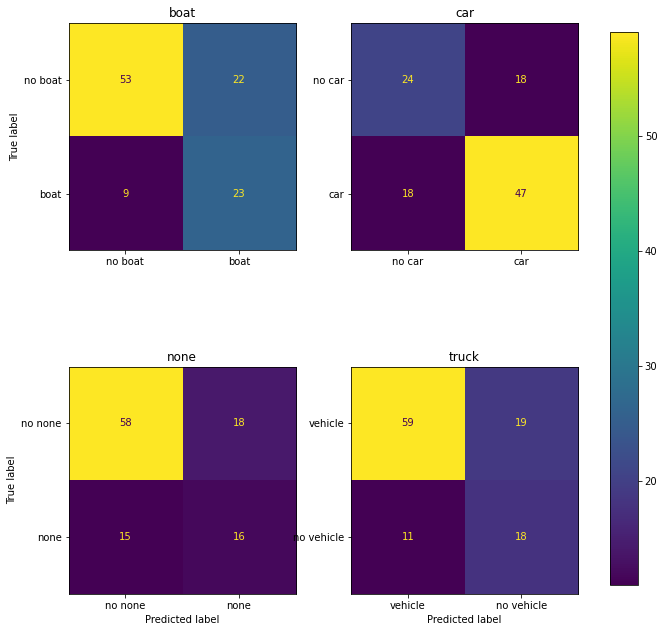

In [48]:
net.load_state_dict(torch.load(get_checkpoint_path(10)))
bonk()

Binary Accuracies: [0.7102803587913513, 0.5514018535614014, 0.6915887594223022, 0.6728971600532532]
FINAL ACCURACY: 65.65%


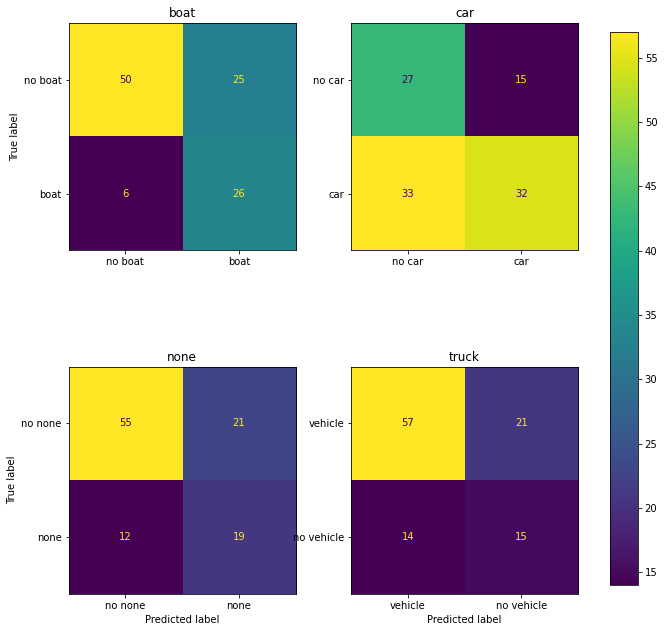

In [49]:
net.load_state_dict(torch.load(get_checkpoint_path(13)))
bonk()

Binary Accuracies: [0.6355140209197998, 0.6261681914329529, 0.7009345293045044, 0.6822429895401001]
FINAL ACCURACY: 66.12%


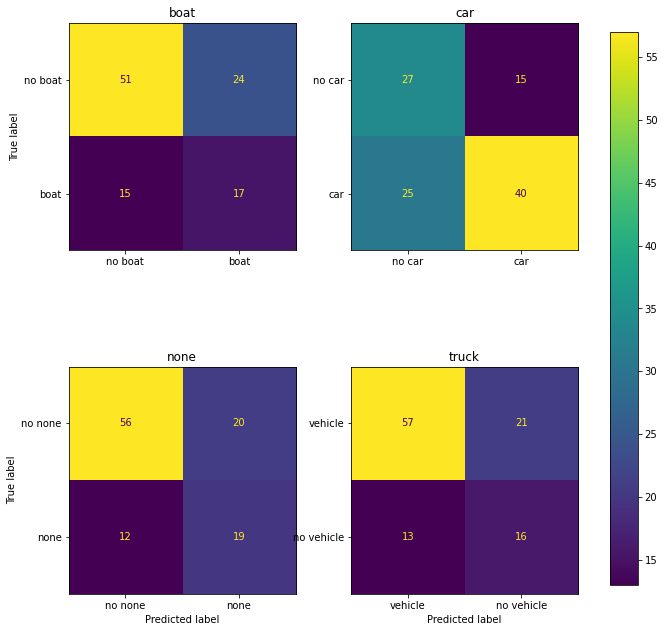

In [50]:
net.load_state_dict(torch.load(get_checkpoint_path(15)))
bonk()

Binary Accuracies: [0.6542055606842041, 0.7383177280426025, 0.7757009267807007, 0.6915887594223022]
FINAL ACCURACY: 71.50%


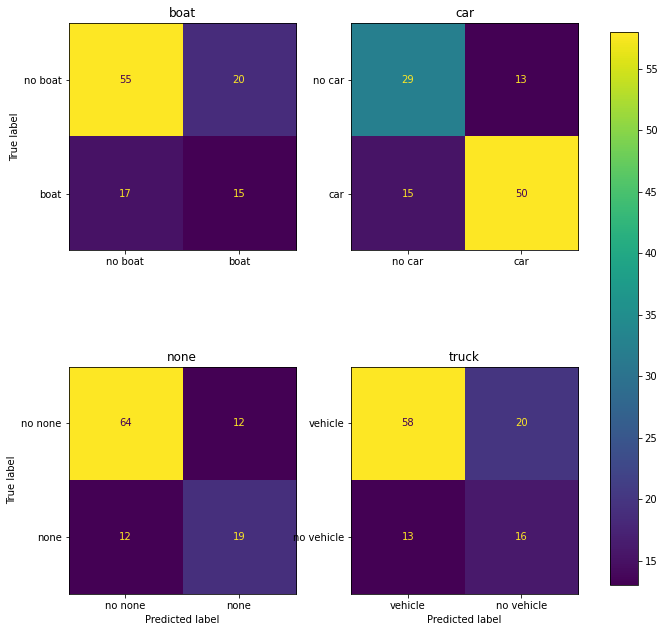

In [51]:
net.load_state_dict(torch.load(get_checkpoint_path(17)))
bonk()

Binary Accuracies: [0.7757009267807007, 0.7009345293045044, 0.7289719581604004, 0.6542055606842041]
FINAL ACCURACY: 71.50%


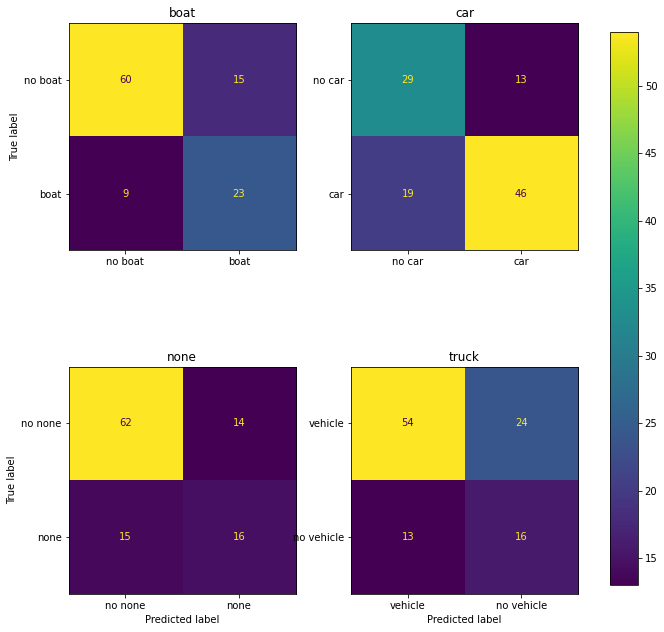

In [52]:
net.load_state_dict(torch.load(get_checkpoint_path(20)))
bonk()

In [62]:
!cd training_images && ls

010_0076_226f1912-dd6c-4b16-afcf-b5166162f179.jpg
010_0077_14ac7011-7767-40af-aa66-720c2074af2f.jpg
010_0082_458c0d4a-ffab-445c-ba5f-dfc6e9831796.jpg
010_0082_458c0d4a-ffab-445c-ba5f-dfc6e9831796.jpg.1
010_0229_3b31b175-af89-4138-ba3f-2553171f69b8.jpg
010_0347_48a0e25d-ffa1-4a4a-abf2-525dd6688fab.jpg
010_0536_ae198881-e513-4c67-b578-be9ba0dfce3a.jpg
010_0553_6f2a7475-1ba4-427f-83b6-18dec1078396.jpg
010_0570_8a6aa1b7-c493-4782-b14f-46be4b08f17a.jpg
010_0635_e4228bd4-dc26-4f6a-8ac0-8553a882872a.jpg
010_1204_08f36e02-9811-481a-b681-ec7be5b586d9.jpg
010_1204_08f36e02-9811-481a-b681-ec7be5b586d9.jpg.1
010_1204_08f36e02-9811-481a-b681-ec7be5b586d9.jpg.2
010_1322_8c775c2c-45e0-4932-8fc6-f8f0ea0a46bd.jpg
010_1394_0194d80e-890a-4b36-938a-e075106b4d6b.jpg
010_2270_e190ef45-e355-4cc6-a6a7-b73a6a144238.jpg
010_2360_409ed17c-ef99-40e0-ad5a-21d1d0f3acb3.jpg
010_2504_c861e534-d0b3-40be-9bfa-a4bf14c55cc2.jpg
010_2526_b5eee215-7e36-4118-9b19-5e43c4d82a45.jpg
010_2547_f6b86518-b62f-4be7-a878-81d5f87a1b9

In [181]:
x = 13
transformed_dataset[x]['image'] # __getitem__ -> []
out  = net(transformed_dataset[x]['image'][np.newaxis, :].cuda()) # adds axis on beginning of shape, then sends to cuda
pred = (torch.sigmoid(out) > 0.5).float()
print(pred == transformed_dataset[x]['damage_labels'].cuda())
pred

tensor([[False,  True,  True,  True]], device='cuda:0')


tensor([[0., 1., 0., 0.]], device='cuda:0')

In [188]:
### TEMP CELL
for x in range(1000):
#     if (torch.equal(transformed_dataset[x]['damage_labels'],torch.tensor([0,1.0,0,1.0]))):
    if (transformed_dataset[x]['damage_labels'].sum() > 1):
        transformed_dataset[x]['image'] # __getitem__ -> []
        out  = net(transformed_dataset[x]['image'][np.newaxis, :].cuda()) # adds axis on beginning of shape, then sends to cuda
        pred = (torch.sigmoid(out) > 0.5).float()
#         print(x)
        if ((pred == transformed_dataset[x]['damage_labels'].cuda()).sum() == 4):
            print(x)
        pred
        

In [ ]:
for x in range(1000):
#     if (torch.equal(transformed_dataset[x]['damage_labels'],torch.tensor([0,1.0,0,1.0]))):
    if (transformed_dataset[x]['damage_labels'].sum() > 1):
        transformed_dataset[x]['image'] # __getitem__ -> []
        out  = net(transformed_dataset[x]['image'][np.newaxis, :].cuda()) # adds axis on beginning of shape, then sends to cuda
        pred = (torch.sigmoid(out) > 0.5).float()
#         print(x)
        if ((pred == transformed_dataset[x]['damage_labels'].cuda()).sum() == 4):
            print(x)
        pred
        

In [120]:
for y in range(100):
    if (transformed_dataset[y]['damage_labels'].sum()) > 1: print(y)

1
6
8
13
18
20
22
23
27
29
30
31
34
35
36
37
38
40
41
42
44
45
47
49
51
52
53
54
57
60
64
67
77
78
80
82
84
86
87
90
91
93
95
98


In [154]:
for y in range(30, 50):
    if (torch.equal(transformed_dataset[y]['damage_labels'],torch.tensor([1.0,1.0,0,0]))): print(y)

31
34
41
45


In [108]:
transformed_dataset[x]

{'image': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'image_name': 'training_images/A0027-92_621b3bc4-4456-4a6c-a2b4-7ac25b75d191.jpg',
 'damage_labels': tensor([0., 1., 0., 0.]),
 'uuid': '535196ef1d8ea36bdf9577d776c433de888309c0',


In [178]:
# find image link from part of name

def filt(row):
    if ('0762c5b7c6d8.jpg' in row):
        print(row)
        return True
    return False
#     return '17f5c49e2f4e' in row
    

test_mat = final_mat.reset_index()
test_mat[test_mat['url'].apply(filt)]

https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9075/614001/A0027-92_8b828d16-41a8-4db0-b1ce-0762c5b7c6d8.jpg


Answer                                                url  vehicle:boat  \
3732    https://ladi.s3-us-west-2.amazonaws.com/Images...             0   

Answer  vehicle:car  vehicle:none  vehicle:truck  
3732              1             0              1

In [179]:
# find idx from image path

for b in range (50):
    
    if "0762c5b7c6d8.jpg" in transformed_dataset[b]['image_name']:
        print(b)
        break

8


In [116]:
img = plt.imread('flood image resized.jpg')
img_in = torch.tensor(img, dtype = torch.float).permute(2,0,1)

In [117]:

# transformed_dataset[x]['image'] # __getitem__ -> []
out  = net(torch.tensor(img_in[np.newaxis, :]).cuda()) # adds axis on beginning of shape, then sends to cuda
pred = (torch.sigmoid(out) > 0.5).float()
# print(pred == transformed_dataset[x]['damage_labels'].cuda())
pred

tensor([[0., 1., 0., 0.]], device='cuda:0')

In [56]:
final_mat.head(100)

Answer                                              vehicle:boat  vehicle:car  \
url                                                                             
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             1            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            0   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazonaws.com/Images/...             0            1   
https://ladi.s3-us-west-2.amazo

In [4]:
t = torch.tensor([[-0.9959, -0.3695, -0.2052, -1.1020],
        [-1.0892,  0.5385, -1.4312, -0.4552],
        [-1.0925,  0.4621, -1.2877, -1.4351],
        [-0.3456,  0.6428, -1.6954, -1.2472],
        [ 0.5607,  0.7997, -2.4258, -2.8630],
        [-1.1303, -0.0915, -0.3979, -1.1001],
        [-0.4397,  0.5132, -1.6950, -0.7830],
        [-1.5754, -0.4496,  0.0905, -0.9139],
        [-0.8523,  0.3894, -1.1621, -0.9062],
        [-1.5975, -0.4554,  0.0991, -0.9200]])

In [5]:
torch.sigmoid(t)

tensor([[0.2697, 0.4087, 0.4489, 0.2494],
        [0.2518, 0.6315, 0.1929, 0.3881],
        [0.2511, 0.6135, 0.2162, 0.1923],
        [0.4144, 0.6554, 0.1551, 0.2232],
        [0.6366, 0.6899, 0.0812, 0.0540],
        [0.2441, 0.4771, 0.4018, 0.2497],
        [0.3918, 0.6256, 0.1551, 0.3137],
        [0.1714, 0.3895, 0.5226, 0.2862],
        [0.2990, 0.5961, 0.2383, 0.2878],
        [0.1683, 0.3881, 0.5248, 0.2850]])

In [ ]:
del inputs
del labels
del outputs
del loss
del PATH

In [33]:
torch.cuda.memory_allocated()

14323907072

In [32]:
torch.cuda.empty_cache()

In [74]:
print(data['damage_labels'])

tensor([[1, 0, 1, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [1, 0, 0, 0],
        [1, 0, 1, 0],
        [1, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 1, 0]])


In [20]:
print(data['image'].shape)
print(data['damage_labels'].shape)

torch.Size([8, 3, 512, 512])
torch.Size([8, 4])


In [19]:
print(outputs.shape)

torch.Size([8, 4])


In [18]:
print(loss.shape)

torch.Size([])


In [21]:
criterion(outputs, labels)

RuntimeError: CUDA error: device-side assert triggered

In [44]:
data['image'][10][0][1]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.7765, 0.7882, 0.7608, 0.7647, 0.7686,
        0.8078, 0.7843, 0.7882, 0.8588, 0.8196, 0.7412, 0.7569, 0.7020, 0.7137,
        0.6471, 0.6627, 0.6431, 0.6784, 0.7176, 0.7176, 0.6980, 0.7412, 0.6941,
        0.6549, 0.6784, 0.6784, 0.6667, 0.6824, 0.6824, 0.6863, 0.6353, 0.6549,
        0.6078, 0.6353, 0.5373, 0.5255, 0.5098, 0.4824, 0.5098, 0.5922, 0.6039,
        0.6627, 0.7020, 0.7098, 0.5765, 0.6118, 0.8196, 0.8078, 0.7922, 0.7255,
        0.6941, 0.6314, 0.6353, 0.5882, 0.6314, 0.5843, 0.6314, 0.6235, 0.6000,
        0.6314, 0.5412, 0.6118, 0.6118, 0.6549, 0.6745, 0.7176, 0.7137, 0.6431,
        0.4627, 0.4196, 0.4980, 0.6157, 

In [61]:
torch.tensor(data['damage_labels'])

TypeError: only integer tensors of a single element can be converted to an index

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
single_iter = dataiter.next()
images = single_iter['image']
labels = single_iter['damage:flood/water']

In [ ]:
net.load_state_dict(torch.load(PATH))

outputs = net(images.cuda())
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % predicted[j].cpu()
                              for j in range(batch_size)))

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images = data['image'].cuda()
        labels = data['damage:flood/water'].cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

In [ ]:
truth_labels = []
predicted_labels = []
with torch.no_grad():
    for data in test_loader:
        images = data['image'].cuda()
        labels = data['damage:flood/water'].cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        truth_labels.append(labels.cpu())
        predicted_labels.append(predicted.cpu())
truth_labels = np.concatenate([x.numpy() for x in truth_labels])
predicted_labels = np.concatenate([x.numpy() for x in predicted_labels])

In [ ]:
import sklearn.metrics
confusion_matrix = sklearn.metrics.confusion_matrix(truth_labels, predicted_labels)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix, ['flood','no flood'])
disp.plot()